In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import cv2
import tarfile
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.__version__

'2.5.0'

In [5]:
# !wget https://conservancy.umn.edu/bitstream/handle/11299/206575/counting.tar.gz?sequence=1&isAllowed=y

In [6]:
# tar = tarfile.open('/content/counting.tar.gz?sequence=1')
# dataset = tar.extractall()
# tar.close()

In [7]:
with open("/content/counting/train/train_ground_truth.txt", "r") as f:
    data = f.readlines()
with open("/content/counting/val/val_ground_truth.txt", "r") as f:
    valid = f.readlines()

In [8]:
type(data)

In [9]:
del data[0]
del valid[0]

In [10]:
data[:5]

In [11]:
valid[:5]

In [12]:
train_filename_origin = []
for i in range(len(data)):
    train_filename_origin.append(data[i][0:16])
    
valid_filename_origin = []
for i in range(len(valid)):
    valid_filename_origin.append(valid[i][0:16])

In [13]:
y_train_origin = []
for i in range(len(data)):
    y_train_origin.append(int(data[i][17]))
    
y_valid_origin = []
for i in range(len(valid)):
    y_valid_origin.append(int(valid[i][17]))

In [14]:
print(len(y_train_origin))
print(len(y_valid_origin))
print(y_train_origin)
print(y_valid_origin)

In [15]:
print(train_filename_origin)
print(len(train_filename_origin))

In [16]:
print(valid_filename_origin)
print(len(valid_filename_origin))

In [17]:
len(y_train_origin)

In [18]:
index = [i for i in range(len(y_train_origin))]
np.random.shuffle(index)
print(index[:5])
print(len(index))

In [19]:
train_filename_shuffled, y_train_shuffled = shuffle(train_filename_origin, y_train_origin)

In [20]:
print(train_filename_shuffled)
print(y_train_shuffled)
source_temp = '/content/counting/train/images/'
i=23321
path_temp = os.path.join(source_temp,train_filename_shuffled[i])
img = cv2.imread(path_temp)
temp = img[:,:,::-1]/255.0
plt.imshow(temp)
plt.xlabel(y_train_shuffled[i])

In [21]:
filenames_shuffled_numpy = np.array(train_filename_shuffled)
X_train_filename, X_test_filename, y_train, y_test = train_test_split(filenames_shuffled_numpy, y_train_shuffled, test_size=0.1, random_state=42)
print(X_train_filename)
print(X_train_filename.shape)
print(len(y_train))
print(X_test_filename)
print(X_test_filename.shape)
print(len(y_test))

In [22]:
print(type(X_train_filename))

In [23]:
X_valid_filename = np.array(valid_filename_origin)
y_valid = y_valid_origin
print(X_valid_filename)
print(X_valid_filename.shape)
print(len(y_valid))

In [24]:
class My_Custom_Generator(keras.utils.Sequence) :
  def __init__(self, image_filenames, labels, batch_size, path) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.path = path

  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)

  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    return np.array([cv2.resize(cv2.imread(os.path.join(self.path,str(file_name))), (200,200),interpolation=cv2.INTER_AREA) for file_name in batch_x])/255.0, np.array(batch_y)

In [25]:
batch_size = 32
my_training_batch_generator = My_Custom_Generator(X_train_filename, y_train, batch_size, '/content/counting/train/images')
my_validation_batch_generator = My_Custom_Generator(X_valid_filename, y_valid, batch_size, '/content/counting/val/images')
my_test_batch_generator = My_Custom_Generator(X_test_filename, y_test, batch_size, '/content/counting/train/images')

In [26]:
opt = tf.keras.optimizers.Adam(lr=0.00001)
base_model = tf.keras.applications.EfficientNetB0(input_shape=[200,200,3],weights="imagenet", include_top=False)
# base_model = tf.keras.applications.Xception(input_shape=[200,200,3],weights="imagenet", include_top=False)
dropout_1=tf.keras.layers.Dropout(rate=0.5)(base_model.output)
avg = tf.keras.layers.GlobalAveragePooling2D()(dropout_1)
dropout_2=tf.keras.layers.Dropout(rate=0.5)(avg)
class_output = tf.keras.layers.Dense(7, activation="softmax")(dropout_2)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[class_output])

# opt = tf.keras.optimizers.Adam(lr=0.00001)
# base_model = tf.keras.applications.EfficientNetB0(input_shape=[200,200,3],weights="imagenet", include_top=False)
# avg = tf.keras.layers.GlobalAveragePooling2D()(base_model,o)
# dropout_2=tf.keras.layers.Dropout(rate=0.5)(avg)
# class_output = tf.keras.layers.Dense(7, activation="softmax")(dropout_2)
# model = tf.keras.models.Model(inputs=[base_model.input], outputs=[class_output])

# opt = tf.keras.optimizers.Adam(lr=0.00001)
# base_model = tf.keras.applications.EfficientNetB0(input_shape=[200,200,3],weights="imagenet", include_top=False)
# dropout_1=tf.keras.layers.Dropout(rate=0.5)(base_model.output)
# avg = tf.keras.layers.GlobalAveragePooling2D()(dropout_1)
# class_output = tf.keras.layers.Dense(7, activation="softmax")(dropout_2)
# model = tf.keras.models.Model(inputs=[base_model.input], outputs=[class_output])

In [27]:
model.summary()

In [28]:
def exponential_decay_fn(epoch):
    return 0.00001*0.1**(epoch/3)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [29]:
model.compile(loss=["sparse_categorical_crossentropy"], optimizer=opt, metrics=["accuracy"])

In [30]:
len(y_train)

In [31]:
model.fit_generator(
    generator=my_training_batch_generator,
    steps_per_epoch = int(len(y_train) // batch_size),
    epochs = 10,
    #  verbose = 1,
    validation_data = my_validation_batch_generator,
    validation_steps = int(len(y_valid) // batch_size),
    callbacks = [lr_scheduler],
    )

In [32]:
model.evaluate_generator(generator = my_test_batch_generator,
                        steps=int(len(y_test) // batch_size))

In [33]:
model.save('my_model.h5')

In [127]:
#start from here
path = '/Users/Lynette/Desktop/detection/train/images'

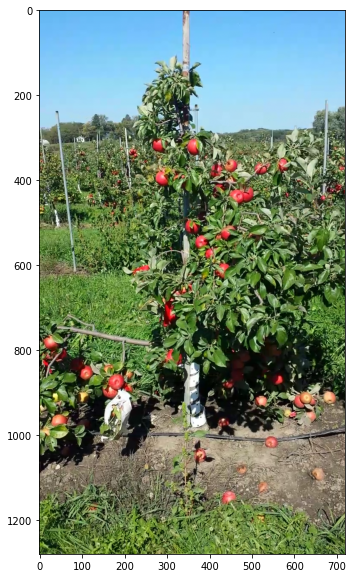

In [209]:
img_path = os.path.join(path,'20150921_132038_image636.png')
img = cv2.imread(img_path)
test_img = img[:,:,::-1]/255.0
plt.figure(figsize=(10,10))
plt.imshow(test_img)
#720*1280

In [210]:
print(test_img.shape)

(1280, 720, 3)


In [211]:
x = 80
y = 80
h = 80
w = 80

145


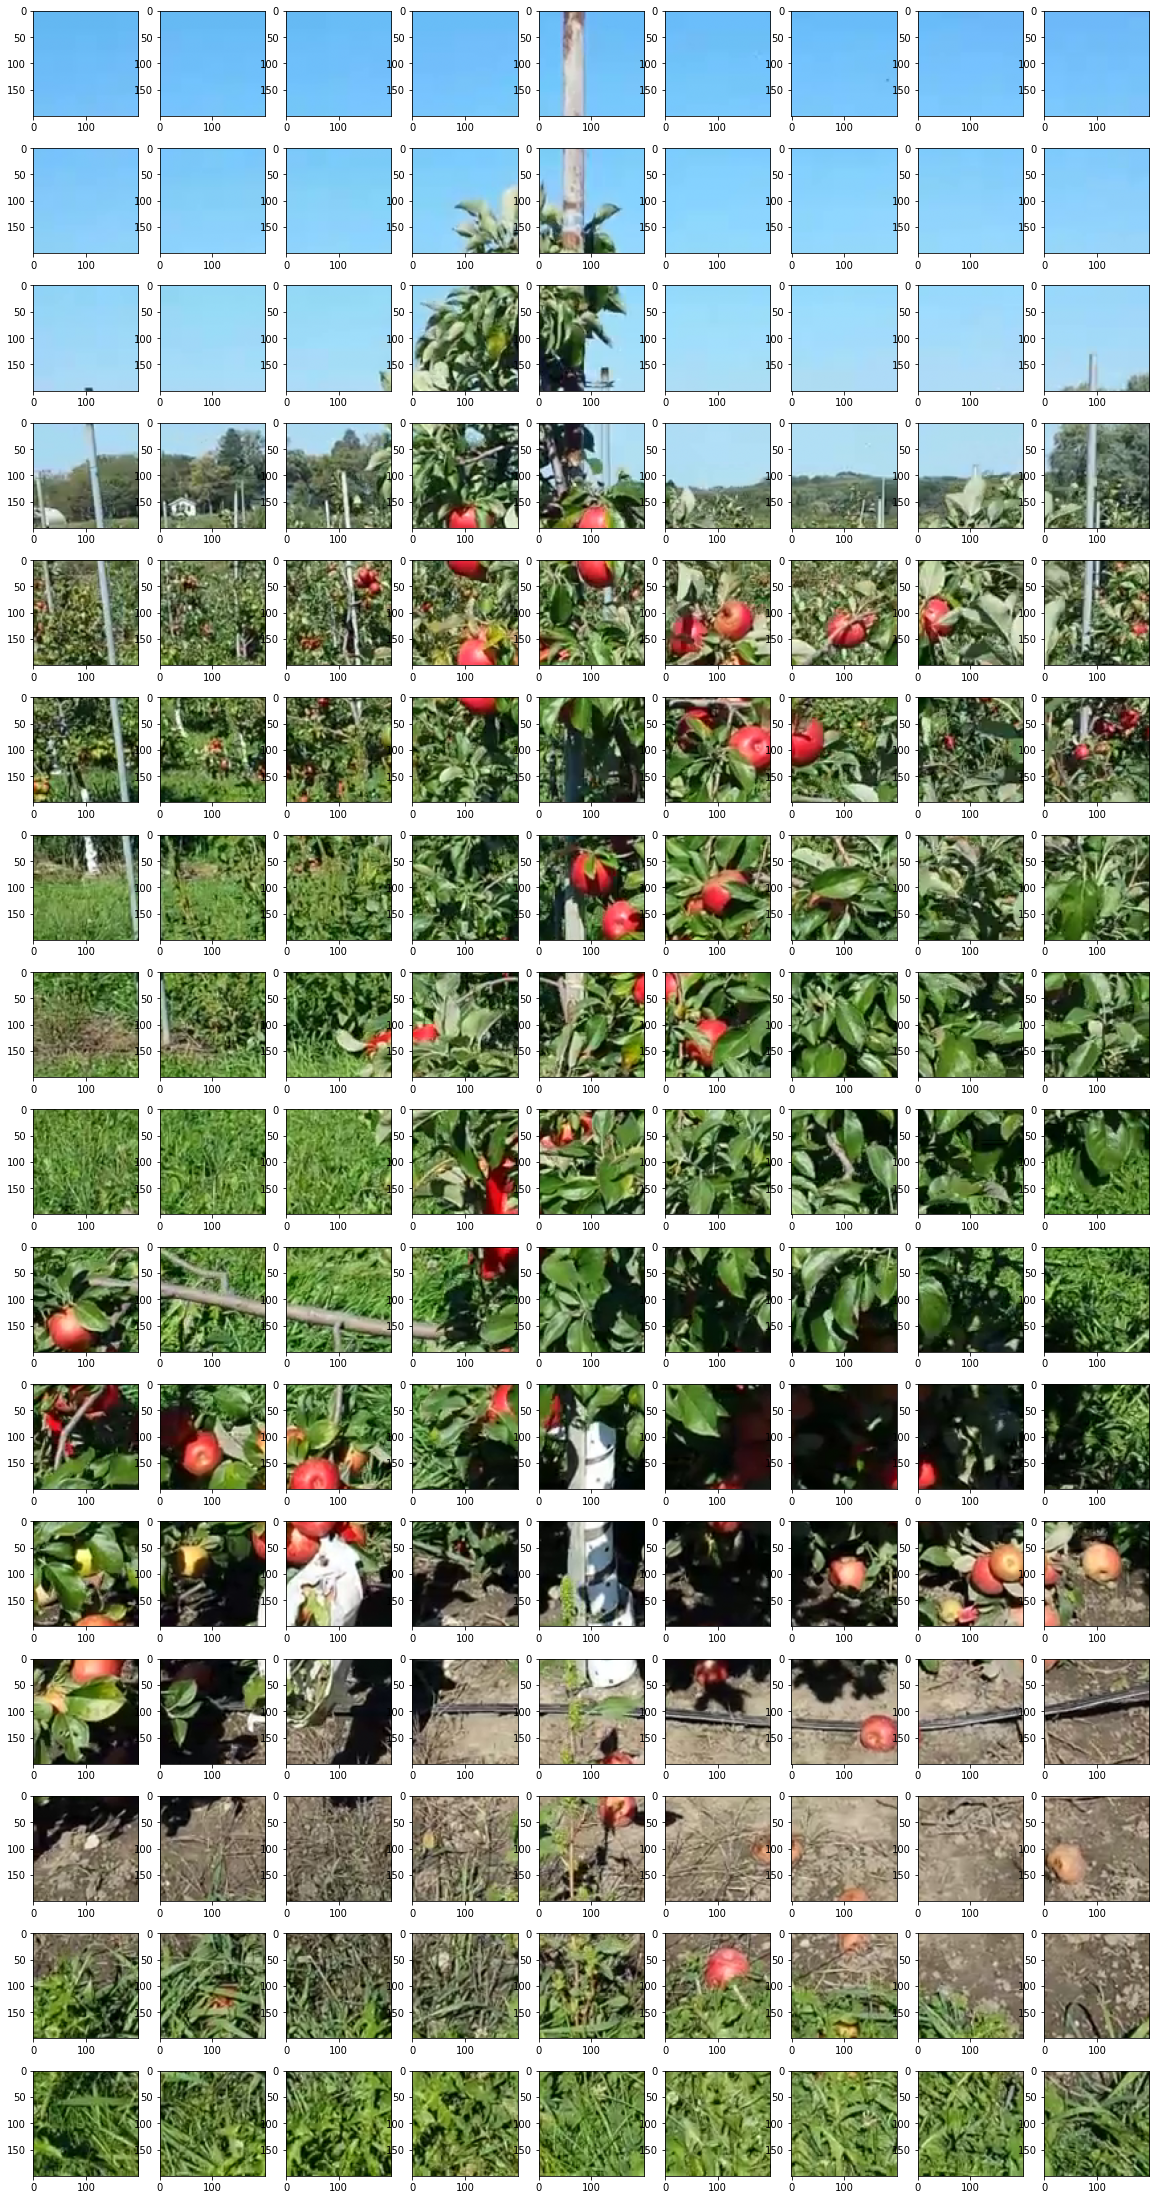

In [212]:
all_image = np.empty((16*9, 200, 200, 3),dtype=float)
k=1
plt.figure(figsize=(20,40))
for i in range(16):
    for j in range(9):
        cropped = test_img[i*y:i*y+h, j*x:j*x+w]
        all_image[k-1] = cv2.resize(cropped,(200,200),interpolation=cv2.INTER_AREA)
        plt.subplot(16,9,k)
        plt.imshow(all_image[k-1])
        k=k+1
print(k)
plt.show()

In [213]:
# load VGG16 with dropout_1
model = keras.models.load_model('/Users/Lynette/Desktop/dropout/ResNet50_dropout_1.h5')

144


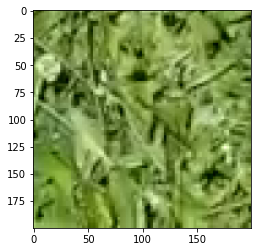

In [214]:
print(len(all_image))
plt.imshow(all_image[140])

In [215]:
# all_apple = 0
# for i in range(len(all_image)):
#     temp = model.predict(all_image[i])
#     predict=np.argmax(temp,axis=1)
#     all_apple = all_apple + predict[0]

In [216]:
all_apple = 0
for i in range(len(all_image)):
    test_of_prediction = np.empty((1, 200, 200, 3),dtype=float)
    test_of_prediction[0]=all_image[i]
    temp = model.predict(test_of_prediction)
    predict=np.argmax(temp,axis=1)
    all_apple = all_apple + predict[0]
    print(predict)
# path = '/Users/Lynette/Desktop/counting/train/images/images_28012.png'
# test_of_prediction = np.empty((1, 200, 200, 3),dtype=float)
# img = cv2.imread(path)
# img = img[:,:,::-1]/255.0
# test_of_prediction[0]=cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)
# temp = model.predict(test_of_prediction)
# predict=np.argmax(temp,axis=1)
# all_apple = all_apple + predict[0]
# print(predict)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[2]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [217]:
print(all_apple)

8
